# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.81KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

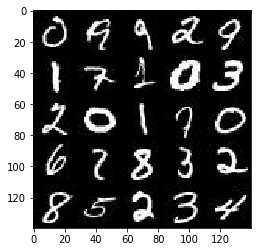

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

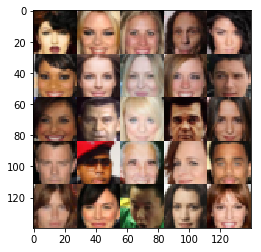

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [30]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    
    #print (image_channels)
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name="learning_rate")


    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # to do, make alpha global
    alpha = 0.2
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        #step 1: apply a convolution to the input with a leaky relu
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x1 = tf.maximum(alpha * x1, x1)
        
        #step 2: add some layers
        # add batch normalization and a leaky relu each step
        x2 = tf.layers.conv2d(x1, 256, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 512, 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        #step 3: flatten the layer and calculate the outputs
        # To Do: parameterize the flat piece to make it more flexible.
        flat = tf.reshape(x3, (-1, 4*4*512))        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits, name="out")

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [32]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 
    
    reuse = not(is_train)
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256 , 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128 , 5, strides=2, padding='same', kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)    
               
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [36]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #saver = tf.train.Saver()
    
    #tf.reset_default_graph()

    _, image_height, image_width, image_dim = data_shape
    inputs_real, inputs_z, l_rate = model_inputs(image_height,image_width, image_dim ,z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
               
                # Run optimizers
                
                #print (batch_images)
                #print (batch_z)
                #print (learning_rate)
       
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, l_rate: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 50, inputs_z, image_dim, data_image_mode)
                   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0700... Generator Loss: 3.8228
Epoch 1/2... Discriminator Loss: 0.0268... Generator Loss: 3.9647
Epoch 1/2... Discriminator Loss: 0.0343... Generator Loss: 4.0536
Epoch 1/2... Discriminator Loss: 10.8109... Generator Loss: 22.4134
Epoch 1/2... Discriminator Loss: 0.0367... Generator Loss: 4.8333
Epoch 1/2... Discriminator Loss: 0.3183... Generator Loss: 2.0746
Epoch 1/2... Discriminator Loss: 2.2413... Generator Loss: 11.6678
Epoch 1/2... Discriminator Loss: 2.1475... Generator Loss: 0.5106
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 3.3403
Epoch 1/2... Discriminator Loss: 0.8182... Generator Loss: 1.2083


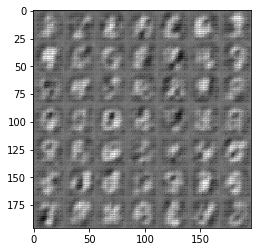

Epoch 1/2... Discriminator Loss: 1.4354... Generator Loss: 0.4893
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.4977
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 2.5250
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 1.0391
Epoch 1/2... Discriminator Loss: 1.4474... Generator Loss: 0.4545
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.5023
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 2.0335
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.7177
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.5293


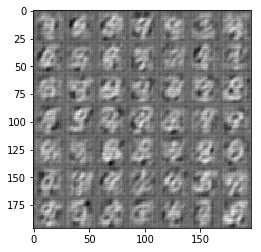

Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 2.2703
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 1.5263
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 0.7223
Epoch 1/2... Discriminator Loss: 0.7905... Generator Loss: 1.7167
Epoch 1/2... Discriminator Loss: 0.6388... Generator Loss: 1.5726
Epoch 1/2... Discriminator Loss: 0.4701... Generator Loss: 1.7078
Epoch 1/2... Discriminator Loss: 0.5278... Generator Loss: 1.7156
Epoch 1/2... Discriminator Loss: 1.3943... Generator Loss: 0.3774
Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 1.7969
Epoch 1/2... Discriminator Loss: 0.6020... Generator Loss: 1.3020


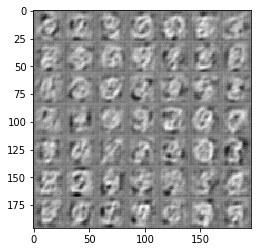

Epoch 1/2... Discriminator Loss: 0.6275... Generator Loss: 1.2610
Epoch 1/2... Discriminator Loss: 0.8344... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 0.4877... Generator Loss: 1.6816
Epoch 1/2... Discriminator Loss: 0.9028... Generator Loss: 0.7259
Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 1.3528
Epoch 1/2... Discriminator Loss: 0.4958... Generator Loss: 1.4115
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 2.7732
Epoch 1/2... Discriminator Loss: 0.8552... Generator Loss: 2.9930
Epoch 1/2... Discriminator Loss: 0.6145... Generator Loss: 1.2030
Epoch 1/2... Discriminator Loss: 1.2494... Generator Loss: 0.5488


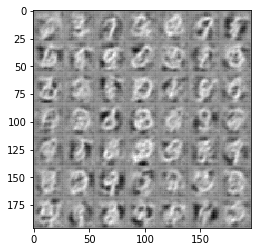

Epoch 1/2... Discriminator Loss: 0.3631... Generator Loss: 1.5836
Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 1.4736
Epoch 1/2... Discriminator Loss: 1.3685... Generator Loss: 0.3896
Epoch 1/2... Discriminator Loss: 1.5530... Generator Loss: 0.3803
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.4314
Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 0.3815
Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.0595
Epoch 1/2... Discriminator Loss: 0.8587... Generator Loss: 1.4037
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 0.8195


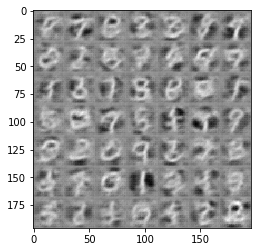

Epoch 1/2... Discriminator Loss: 0.8706... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 2.3208
Epoch 1/2... Discriminator Loss: 1.0569... Generator Loss: 0.5975
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 0.7749
Epoch 1/2... Discriminator Loss: 0.8481... Generator Loss: 1.6280
Epoch 1/2... Discriminator Loss: 1.0575... Generator Loss: 2.1119
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 2.7900
Epoch 1/2... Discriminator Loss: 0.7058... Generator Loss: 1.2876
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 0.7154... Generator Loss: 1.0874


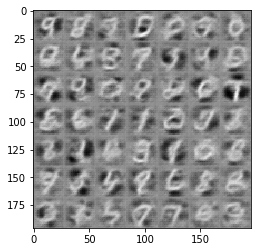

Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 0.8242... Generator Loss: 1.7283
Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.6695
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.1113
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 2.7708
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.7236
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 2.0807
Epoch 1/2... Discriminator Loss: 0.8109... Generator Loss: 0.8286


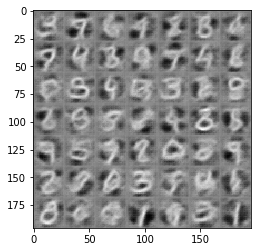

Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 0.7565... Generator Loss: 1.5010
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 1.2792
Epoch 1/2... Discriminator Loss: 1.6892... Generator Loss: 0.2822
Epoch 1/2... Discriminator Loss: 0.7290... Generator Loss: 1.1214
Epoch 1/2... Discriminator Loss: 1.6789... Generator Loss: 0.3668
Epoch 1/2... Discriminator Loss: 0.9657... Generator Loss: 1.8117
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.3793
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 1.1803... Generator Loss: 0.4886


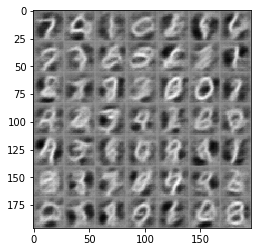

Epoch 1/2... Discriminator Loss: 0.7337... Generator Loss: 2.1754
Epoch 1/2... Discriminator Loss: 1.2308... Generator Loss: 3.4661
Epoch 1/2... Discriminator Loss: 0.7316... Generator Loss: 1.3732
Epoch 1/2... Discriminator Loss: 1.1230... Generator Loss: 0.6052
Epoch 1/2... Discriminator Loss: 1.4421... Generator Loss: 0.4241
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.5911
Epoch 1/2... Discriminator Loss: 0.9042... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 0.9909... Generator Loss: 0.6854
Epoch 1/2... Discriminator Loss: 0.9539... Generator Loss: 0.7442
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 1.3496


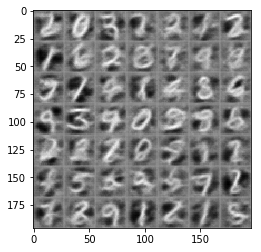

Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 2.8999
Epoch 1/2... Discriminator Loss: 1.2705... Generator Loss: 0.5035
Epoch 1/2... Discriminator Loss: 0.8184... Generator Loss: 1.2306
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 0.7127... Generator Loss: 1.2189
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 0.5576
Epoch 2/2... Discriminator Loss: 0.6693... Generator Loss: 1.3197
Epoch 2/2... Discriminator Loss: 0.7279... Generator Loss: 0.9635
Epoch 2/2... Discriminator Loss: 0.6089... Generator Loss: 1.4542
Epoch 2/2... Discriminator Loss: 0.6293... Generator Loss: 1.3798


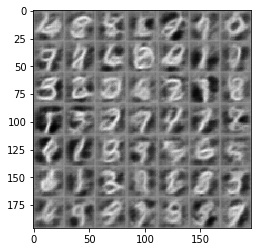

Epoch 2/2... Discriminator Loss: 2.2048... Generator Loss: 0.2891
Epoch 2/2... Discriminator Loss: 0.7744... Generator Loss: 0.9899
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 0.6809... Generator Loss: 1.4055
Epoch 2/2... Discriminator Loss: 0.7040... Generator Loss: 1.0571
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 1.8911
Epoch 2/2... Discriminator Loss: 0.6385... Generator Loss: 1.1584
Epoch 2/2... Discriminator Loss: 0.6584... Generator Loss: 1.0697
Epoch 2/2... Discriminator Loss: 1.4476... Generator Loss: 0.4048
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 1.2074


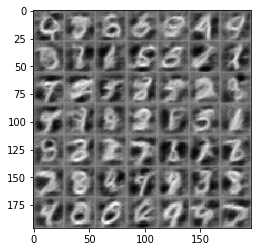

Epoch 2/2... Discriminator Loss: 0.7508... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.2611
Epoch 2/2... Discriminator Loss: 0.7962... Generator Loss: 0.8325
Epoch 2/2... Discriminator Loss: 0.8269... Generator Loss: 1.0406
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 0.5249... Generator Loss: 1.9063
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 0.8694
Epoch 2/2... Discriminator Loss: 3.5300... Generator Loss: 0.0551
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.6269
Epoch 2/2... Discriminator Loss: 0.6257... Generator Loss: 1.0938


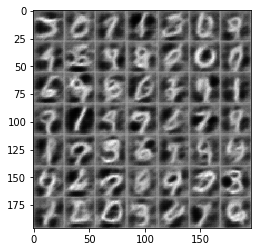

Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 0.9557
Epoch 2/2... Discriminator Loss: 1.1914... Generator Loss: 0.5428
Epoch 2/2... Discriminator Loss: 0.6719... Generator Loss: 1.1115
Epoch 2/2... Discriminator Loss: 0.6945... Generator Loss: 1.3296
Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 0.8002
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 0.5288... Generator Loss: 1.7243
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 2.6043
Epoch 2/2... Discriminator Loss: 0.8462... Generator Loss: 1.2806
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.9395


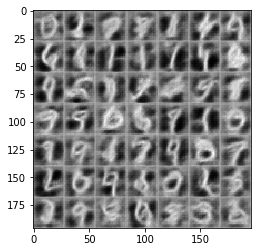

Epoch 2/2... Discriminator Loss: 0.5342... Generator Loss: 2.1850
Epoch 2/2... Discriminator Loss: 0.8198... Generator Loss: 0.9407
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.5549
Epoch 2/2... Discriminator Loss: 1.0201... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 0.6447... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.4853
Epoch 2/2... Discriminator Loss: 1.2818... Generator Loss: 0.4743
Epoch 2/2... Discriminator Loss: 1.2097... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.5916
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 0.7969


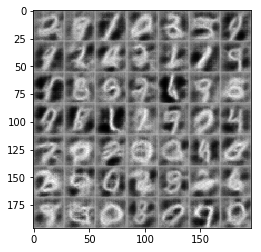

Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.5367
Epoch 2/2... Discriminator Loss: 0.8370... Generator Loss: 1.2490
Epoch 2/2... Discriminator Loss: 0.9210... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 2.2116... Generator Loss: 0.2342
Epoch 2/2... Discriminator Loss: 0.6118... Generator Loss: 1.1945
Epoch 2/2... Discriminator Loss: 0.6232... Generator Loss: 1.4857
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.1667
Epoch 2/2... Discriminator Loss: 0.7828... Generator Loss: 1.9447
Epoch 2/2... Discriminator Loss: 1.1784... Generator Loss: 0.5349


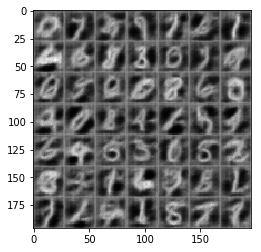

Epoch 2/2... Discriminator Loss: 1.5157... Generator Loss: 0.4117
Epoch 2/2... Discriminator Loss: 0.9966... Generator Loss: 0.6905
Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 0.9003
Epoch 2/2... Discriminator Loss: 0.6714... Generator Loss: 1.3683
Epoch 2/2... Discriminator Loss: 0.5195... Generator Loss: 1.5266
Epoch 2/2... Discriminator Loss: 1.7461... Generator Loss: 0.3646
Epoch 2/2... Discriminator Loss: 1.3269... Generator Loss: 0.4632
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 0.8154... Generator Loss: 0.8754
Epoch 2/2... Discriminator Loss: 1.0104... Generator Loss: 0.6618


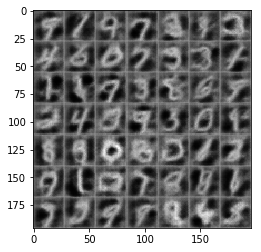

Epoch 2/2... Discriminator Loss: 2.0682... Generator Loss: 0.3037
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 1.8322
Epoch 2/2... Discriminator Loss: 0.6185... Generator Loss: 1.9587
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.0681
Epoch 2/2... Discriminator Loss: 0.7779... Generator Loss: 0.9211
Epoch 2/2... Discriminator Loss: 0.6965... Generator Loss: 1.1138
Epoch 2/2... Discriminator Loss: 0.5024... Generator Loss: 1.3615
Epoch 2/2... Discriminator Loss: 0.6160... Generator Loss: 1.2585
Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 0.9264
Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 0.8925


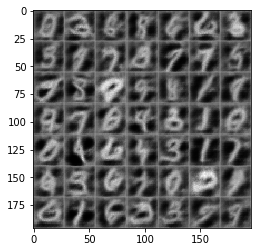

Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 1.1114
Epoch 2/2... Discriminator Loss: 0.7399... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.6927
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 2.6855
Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 0.5505
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 2.3919
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 1.0545
Epoch 2/2... Discriminator Loss: 0.8838... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.0573... Generator Loss: 0.5997
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.2096


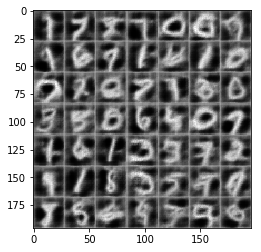

Epoch 2/2... Discriminator Loss: 0.8359... Generator Loss: 2.8449
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 0.8584
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 0.6419... Generator Loss: 1.5345
Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.4899
Epoch 2/2... Discriminator Loss: 0.4960... Generator Loss: 1.5056
Epoch 2/2... Discriminator Loss: 0.9419... Generator Loss: 0.8065


IndexError: list index out of range

In [37]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1211... Generator Loss: 3.2075
Epoch 1/1... Discriminator Loss: 3.0517... Generator Loss: 42.4002
Epoch 1/1... Discriminator Loss: 0.0562... Generator Loss: 35.8710
Epoch 1/1... Discriminator Loss: 0.0037... Generator Loss: 32.4626
Epoch 1/1... Discriminator Loss: 0.5345... Generator Loss: 2.3723
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 2.4522
Epoch 1/1... Discriminator Loss: 0.3209... Generator Loss: 6.4177
Epoch 1/1... Discriminator Loss: 0.2887... Generator Loss: 8.8955
Epoch 1/1... Discriminator Loss: 0.2830... Generator Loss: 2.1957
Epoch 1/1... Discriminator Loss: 0.1733... Generator Loss: 2.4121


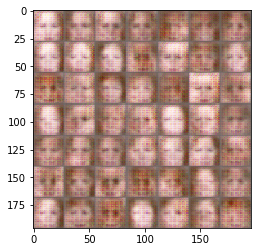

Epoch 1/1... Discriminator Loss: 0.0248... Generator Loss: 4.4583
Epoch 1/1... Discriminator Loss: 0.2653... Generator Loss: 16.1552
Epoch 1/1... Discriminator Loss: 8.4247... Generator Loss: 19.5436
Epoch 1/1... Discriminator Loss: 1.7901... Generator Loss: 10.5820
Epoch 1/1... Discriminator Loss: 0.2530... Generator Loss: 2.7309
Epoch 1/1... Discriminator Loss: 0.4401... Generator Loss: 2.2988
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.5603
Epoch 1/1... Discriminator Loss: 0.5242... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.5598
Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.4177


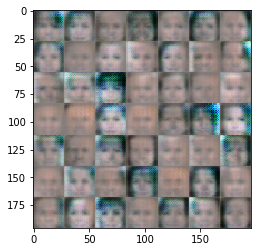

Epoch 1/1... Discriminator Loss: 6.3175... Generator Loss: 8.3940
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 3.0588
Epoch 1/1... Discriminator Loss: 0.2236... Generator Loss: 4.4009
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 2.7654
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 1.9754
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 2.2744
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 3.2332... Generator Loss: 0.0528


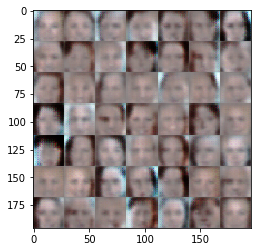

Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 0.9361... Generator Loss: 0.9650
Epoch 1/1... Discriminator Loss: 2.3790... Generator Loss: 0.1714
Epoch 1/1... Discriminator Loss: 0.1857... Generator Loss: 2.8257
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 0.5916... Generator Loss: 2.3972


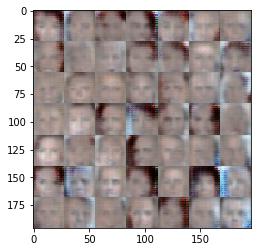

Epoch 1/1... Discriminator Loss: 0.8398... Generator Loss: 2.5025
Epoch 1/1... Discriminator Loss: 0.8625... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 3.2557... Generator Loss: 3.6618
Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.3239
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 2.5809
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.0131... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 2.1359
Epoch 1/1... Discriminator Loss: 1.0203... Generator Loss: 1.2898


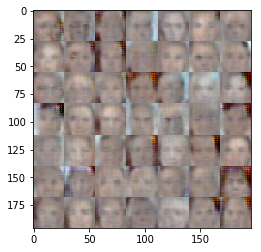

Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 2.7430
Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.8795
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 1.0546
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6879
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.9105


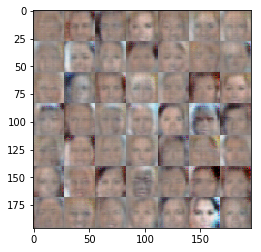

Epoch 1/1... Discriminator Loss: 0.8421... Generator Loss: 1.9878
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 1.9640
Epoch 1/1... Discriminator Loss: 3.0788... Generator Loss: 0.0592
Epoch 1/1... Discriminator Loss: 0.8200... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.9608
Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 2.1799
Epoch 1/1... Discriminator Loss: 0.6932... Generator Loss: 2.7018


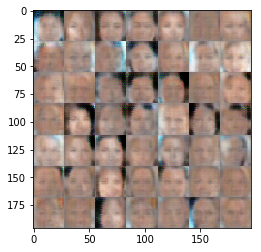

Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 0.7260... Generator Loss: 1.5316
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 2.8341
Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 1.8589
Epoch 1/1... Discriminator Loss: 2.3882... Generator Loss: 4.0702
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 1.0181
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 2.7281


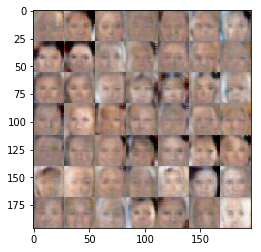

Epoch 1/1... Discriminator Loss: 0.6348... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 0.3450... Generator Loss: 2.7074
Epoch 1/1... Discriminator Loss: 1.0827... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.5092
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 1.8201
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 0.7097... Generator Loss: 1.4777


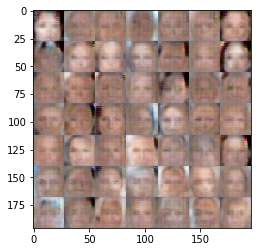

Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 2.2736
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 1.4280
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 1.7401... Generator Loss: 0.2620
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 2.2678
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 0.8244... Generator Loss: 1.9706


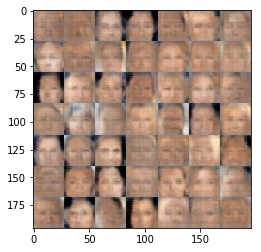

Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.4807
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.3883
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.3421
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 1.8531
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.8956
Epoch 1/1... Discriminator Loss: 1.8234... Generator Loss: 3.1427
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.2505


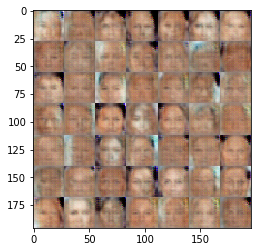

Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 1.3655
Epoch 1/1... Discriminator Loss: 2.9039... Generator Loss: 0.0727
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.6482
Epoch 1/1... Discriminator Loss: 2.5723... Generator Loss: 3.9431
Epoch 1/1... Discriminator Loss: 2.0489... Generator Loss: 0.1874
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.0846
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 1.1910


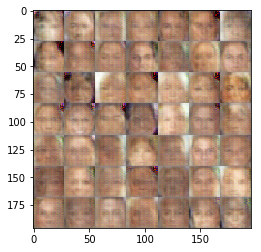

Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 0.4298... Generator Loss: 1.4773
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.9509... Generator Loss: 0.2213
Epoch 1/1... Discriminator Loss: 1.3212... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.4007
Epoch 1/1... Discriminator Loss: 1.5728... Generator Loss: 0.3124


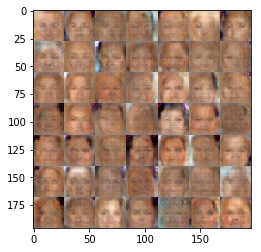

Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.0542... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.1377
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.9108


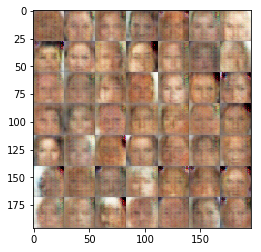

Epoch 1/1... Discriminator Loss: 0.3273... Generator Loss: 3.0536
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.3360
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 1.6142
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 2.7904


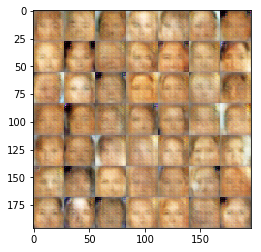

Epoch 1/1... Discriminator Loss: 1.8112... Generator Loss: 0.2206
Epoch 1/1... Discriminator Loss: 1.1681... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 1.7353
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 1.2173
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.6589
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.9242


IndexError: list index out of range

In [38]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.